In [1]:
import sys
sys.path.append('/Users/tianmuzhang/Google Drive/My_Py_Mods/MD_barcode')
# sys.path.append('/Users/tianmuzhang/Google Drive/My_Py_Mods/')
import read_lammps_dump
# from My_Py_Mods import read_lammps_dump2
import os
import numpy as np
import pickle
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# from sklearn.neighbors import NearestNeighbors

import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

import dionysus as ds

%matplotlib inline

### generate barcode for Silicon atoms for all of the simulation

In [2]:
fn_to_read = []
for fldr in os.listdir():
    if fldr.startswith('15'):
        fn_to_read.append(fldr)

In [17]:
rd_ele = 'Si' # set read element
bond_thres = 5.5
# got an error, since one of the simulations do not have any Si. continue with the rest.
for comps in ['15Na10Ca37B38Si', '15Na10Ca50B25Si', '15Na10Ca24B51Si']:
# for comps in fn_to_read:
    print('Read lammpstrj file: '+comps)
    trj_fn = './'+comps+'/dump.quench.lammpstrj'
    read_out_ele = read_lammps_dump.read_lammps_atoms(trj_fn, element_to_read=[rd_ele], 
                                                  wrapped_out=True, scaled_out=False,
                                                 every_time_frames=10,
#                                                   every_time_frames=2,
                                                 )
    
    print('Parsing edges and triangles: '+comps)
    edg_dic = {} # initialize dictionary for edges and triangles
    tri_dic = {}
    crt_edg_set = frozenset([]) # initialize current sets for edges and triangles
    crt_tri_set = frozenset([])
    for tt, ffmm in zip(read_out_ele[0], read_out_ele[1][rd_ele]):
        # distance matrix, using sorting keys so the unique atoms can be tracked across
        # from different frames
        dismat = squareform(pdist(np.array([ffmm[kk] for kk in  sorted(ffmm.keys())])))
        # graph, used for getting cliques
        G = nx.from_numpy_array(dismat < bond_thres)
        # get clieques
        nxt_edg_set = frozenset([frozenset(clq) for clq in nx.enumerate_all_cliques(G) if len(clq)==2])
        nxt_tri_set = frozenset([frozenset(clq) for clq in nx.enumerate_all_cliques(G) if len(clq)==3])
        # get symm. difference, so the result is used to indicate the enter/exit of the simplices in the complex
        edg_chg_set = crt_edg_set.symmetric_difference(nxt_edg_set)
        tri_chg_set = crt_tri_set.symmetric_difference(nxt_tri_set)

        # add enter/exit times to the dictionary of edges/triangles
        for edg_ss in edg_chg_set:
            try:
                edg_dic[edg_ss] = edg_dic[edg_ss] + [tt]
    #             edg_dic[edg_ss] = edg_dic[edg_ss].append(tt)
            except KeyError:
                edg_dic[edg_ss] = [tt]
        for tri_ss in tri_chg_set:
            try:
                tri_dic[tri_ss] = tri_dic[tri_ss] + [tt]
    #             tri_dic[tri_ss] = edg_dic.append(tt)
            except KeyError:
                tri_dic[tri_ss] = [tt]
        # update current to next
        crt_edg_set = nxt_edg_set
        crt_tri_set = nxt_tri_set
    
    print('Assembling filtration: '+comps)
    # set lists for 0-simplices and their times, the frame 10 is arbitrarily chosen as
    # the atoms are the same for all of the frames. -1 is used due to the fact that
    # LAMMPS starting index is 1, python is 0.
    vt_list = [[vtt-1] for vtt in sorted(read_out_ele[1][rd_ele][10].keys())]
    vt_times = [[read_out_ele[0][0]]]*len(sorted(read_out_ele[1][rd_ele][10].keys()))
    
    # Edges and their times
    edg_list = []
    edg_times = []
    for ee, tt in edg_dic.items():
        edg_list.append(list(ee))
        edg_times.append(tt)
    # Triangles and their times.
    tri_list = []
    tri_times = []
    for ee, tt in tri_dic.items():
        tri_list.append(list(ee))
        tri_times.append(tt)
    
    simp_all = vt_list + edg_list + tri_list
    times_all = vt_times + edg_times + tri_times
    
    print('Calculating zigzag persistence: '+comps)
    # Zigzag persistence
    zz, dgms, cells = ds.zigzag_homology_persistence(ds.Filtration(simp_all), times_all)
    
    with open('./zigzag_results/Si/'+comps+'.pkl', 'wb') as fp:
        pickle.dump(dgms, fp)

Read lammpstrj file: 15Na10Ca37B38Si
Parsing edges and triangles: 15Na10Ca37B38Si
Assembling filtration: 15Na10Ca37B38Si
Calculating zigzag persistence: 15Na10Ca37B38Si
Read lammpstrj file: 15Na10Ca50B25Si
Parsing edges and triangles: 15Na10Ca50B25Si
Assembling filtration: 15Na10Ca50B25Si
Calculating zigzag persistence: 15Na10Ca50B25Si
Read lammpstrj file: 15Na10Ca24B51Si
Parsing edges and triangles: 15Na10Ca24B51Si
Assembling filtration: 15Na10Ca24B51Si
Calculating zigzag persistence: 15Na10Ca24B51Si


In [28]:
# fn_to_read
dgms

[Diagram with 1208 points, Diagram with 8077 points, Diagram with 8589 points]

In [44]:
os.listdir('./zigzag_results/Si/')[3].split('.')

['15Na10Ca75Si', 'pkl']

In [36]:
with open('./zigzag_results/Si/15Na10Ca75Si.pkl', 'rb') as fp:
    dgms = pickle.load(fp)

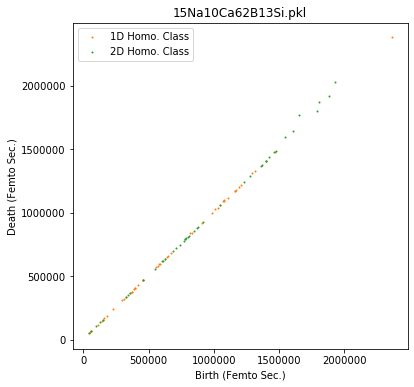

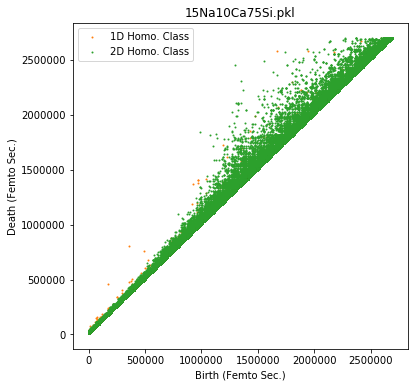

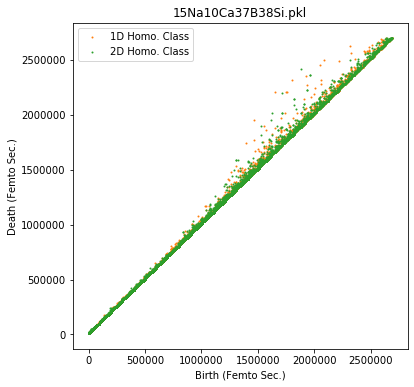

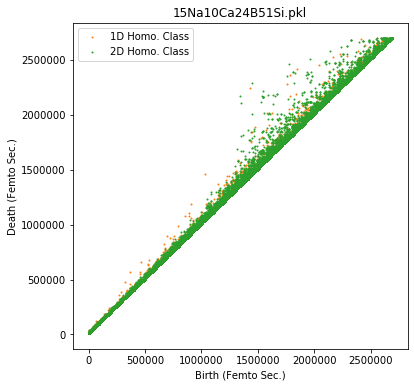

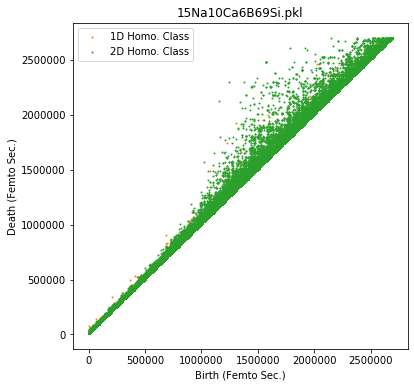

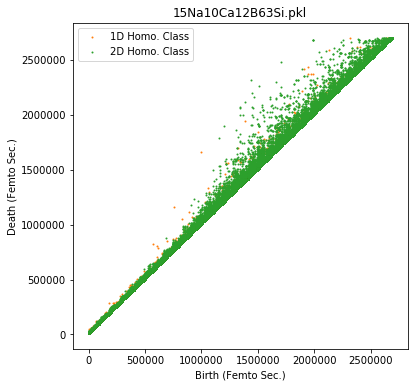

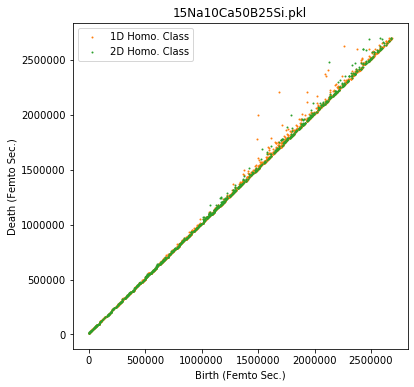

In [45]:
for fn in os.listdir('./zigzag_results/Si/'):
    if fn.startswith('15'):
        with open('./zigzag_results/Si/'+fn, 'rb') as fp:
            dgms = pickle.load(fp)
    else:
        continue
    
    fig1 = plt.figure(figsize=(6,6))
    ax1 = fig1.add_subplot(111)
    yy = 1
    pts0b = []
    pts0d = []
    pts1b = []
    pts1d = []
    pts2b = []
    pts2d = []
    for bar in dgms[0]:
    #     ax1.scatter(bar.birth, bar.death, c='C0')
        pts0b.append(bar.birth)
        pts0d.append(bar.death)
    # ax1.scatter(x=pts0b, y=pts0d, c='C0', label='0D Homo. Class', s=1)
    for bar in dgms[1]:
        pts1b.append(bar.birth)
        pts1d.append(bar.death)
    ax1.scatter(x=pts1b, y=pts1d, c='C1', label='1D Homo. Class', s=1)

    for bar in dgms[2]:
        pts2b.append(bar.birth)
        pts2d.append(bar.death)
    ax1.scatter(x=pts2b, y=pts2d, c='C2', label='2D Homo. Class', s=1)

    ax1.set_xlabel('Birth (Femto Sec.)')
    ax1.set_ylabel('Death (Femto Sec.)')
    ax1.legend()
    ax1.set_title(fn.split()[0])
    #     ax1.scatter(bar.birth, bar.death, c='C1')
    #     ax1.plot([bar.birth, bar.death], [yy, yy])
    #     yy += 1
    fig1.savefig('./zigzag_results/Si/figs/'+fn.split('.')[0]+'.png', dpi=250, bbox_inches='tight')

## All atoms all elements for 37B38Si

In [40]:
rd_ele = ['B', 'Si', 'Na', 'Ca', 'O']
trj_fn = './15Na10Ca37B38Si/dump.quench.lammpstrj'#+comps+'/dump.quench.lammpstrj'
read_out_ele = read_lammps_dump.read_lammps_atoms(trj_fn, element_to_read=rd_ele, 
                                                  wrapped_out=True, scaled_out=False,
                                                 every_time_frames=10,
#                                                   every_time_frames=2,
                                                 )

In [41]:
# read_out_ele[1]['Ca'][100]
edg_dic = {} # initialize dictionary for edges, triangles and tetrahedra
tri_dic = {}
ttr_dic = {}
crt_edg_set = frozenset([]) # initialize current sets for edges, triangles and tetrahedra
crt_tri_set = frozenset([])
crt_ttr_set = frozenset([])
bond_thres = 2.0
for tt, ffmmB, ffmmSi, ffmmNa, ffmmCa, ffmmO in zip(read_out_ele[0], 
                                             read_out_ele[1]['B'], read_out_ele[1]['Si'],
                                            read_out_ele[1]['Na'], read_out_ele[1]['Ca'],
                                            read_out_ele[1]['O']):
    ffmm = {**ffmmB, **ffmmSi, **ffmmNa, **ffmmCa, **ffmmO}
    dismat = squareform(pdist(np.array([ffmm[kk] for kk in  sorted(ffmm.keys())])))
    # graph, used for getting cliques
    G = nx.from_numpy_array(dismat < bond_thres)
    # get clieques
    nxt_edg_set = frozenset([frozenset(clq) for clq in nx.enumerate_all_cliques(G) if len(clq)==2])
    nxt_tri_set = frozenset([frozenset(clq) for clq in nx.enumerate_all_cliques(G) if len(clq)==3])
    nxt_ttr_set = frozenset([frozenset(clq) for clq in nx.enumerate_all_cliques(G) if len(clq)==4])
    # get symm. difference, so the result is used to indicate the enter/exit of the simplices in the complex
    edg_chg_set = crt_edg_set.symmetric_difference(nxt_edg_set)
    tri_chg_set = crt_tri_set.symmetric_difference(nxt_tri_set)
    ttr_chg_set = crt_ttr_set.symmetric_difference(nxt_ttr_set)
    
    # add enter/exit times to the dictionary of edges/triangles
    for edg_ss in edg_chg_set:
        try:
            edg_dic[edg_ss] = edg_dic[edg_ss] + [tt]
#             edg_dic[edg_ss] = edg_dic[edg_ss].append(tt)
        except KeyError:
            edg_dic[edg_ss] = [tt]
    for tri_ss in tri_chg_set:
        try:
            tri_dic[tri_ss] = tri_dic[tri_ss] + [tt]
#             tri_dic[tri_ss] = edg_dic.append(tt)
        except KeyError:
            tri_dic[tri_ss] = [tt]
            
    for ttr_ss in ttr_chg_set:
        try:
            ttr_dic[ttr_ss] = ttr_dic[ttr_ss] + [tt]
#             tri_dic[tri_ss] = edg_dic.append(tt)
        except KeyError:
            ttr_dic[ttr_ss] = [tt]
    # update current to next
    crt_edg_set = nxt_edg_set
    crt_tri_set = nxt_tri_set
    crt_ttr_set = nxt_ttr_set
    
# set lists for 0-simplices and their times, the frame 10 is arbitrarily chosen as
# the atoms are the same for all of the frames. -1 is used due to the fact that
# LAMMPS starting index is 1, python is 0.
vt_list = [[vtt-1] for vtt in sorted(ffmm.keys())]
vt_times = [[read_out_ele[0][0]]]*len(sorted(ffmm.keys()))

# Edges and their times
edg_list = []
edg_times = []
for ee, tt in edg_dic.items():
    edg_list.append(list(ee))
    edg_times.append(tt)
# Triangles and their times.
tri_list = []
tri_times = []
for ee, tt in tri_dic.items():
    tri_list.append(list(ee))
    tri_times.append(tt)
    
ttr_list = []
ttr_times = []
for ee, tt in ttr_dic.items():
    ttr_list.append(list(ee))
    ttr_times.append(tt)

simp_all = vt_list + edg_list + tri_list + ttr_list
times_all = vt_times + edg_times + tri_times + ttr_times

print('Calculating zigzag persistence: ')
# Zigzag persistence
zz, dgms, cells = ds.zigzag_homology_persistence(ds.Filtration(simp_all), times_all)

with open('./zigzag_results/B37Si38/all.pkl', 'wb') as fp:
    pickle.dump(dgms, fp)

Calculating zigzag persistence: 


In [42]:
# len(ffmm)
# len(read_out_ele[1]['B'][1].keys()) + len(read_out_ele[1]['Ca'][-1].keys()) + len(read_out_ele[1]['Si'][-1].keys()) + len(read_out_ele[1]['Na'][-1].keys())
with open('./zigzag_results/B37Si38/all.pkl', 'rb') as fp:
    dgms = pickle.load(fp)

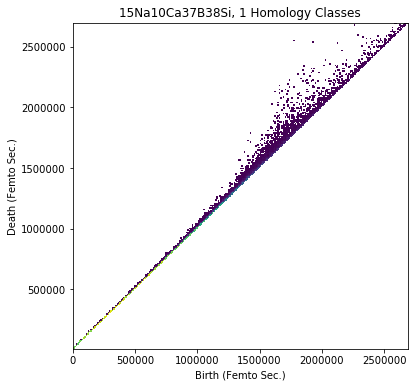

In [92]:
# dgms[1][3001]
# for fn in os.listdir('./zigzag_results/Si/'):
#     if fn.startswith('15'):
#         with open('./zigzag_results/Si/'+fn, 'rb') as fp:
#             dgms = pickle.load(fp)
#     else:
#         continue
        
with open('./zigzag_results/B37Si38/all.pkl', 'rb') as fp:
    dgms = pickle.load(fp)

fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111)

pts0b = []
pts0d = []
pts1b = []
pts1d = []
pts2b = []
pts2d = []
for bar in dgms[0]:
#     ax1.scatter(bar.birth, bar.death, c='C0')
    pts0b.append(bar.birth)
    pts0d.append(bar.death)
# ax1.scatter(x=pts0b, y=pts0d, c='C0', label='0D Homo. Class', s=1)
for bar in dgms[1]:
    if not np.isinf(bar.death):
        pts1b.append(bar.birth)
        pts1d.append(bar.death)
    
H, xedges, yedges = np.histogram2d(x=np.array(pts1b), y=np.array(pts1d), bins=1000)
# ax1.matshow(H.T)
plt.hist2d(x=pts1b, y=pts1d, bins=500, cmin=1)
# ax1.scatter(x=pts1b, y=pts1d, c='C1', label='1D Homo. Class', s=1)
# ax1.scatter(1,np.inf)

# for bar in dgms[2]:
#     pts2b.append(bar.birth)
#     pts2d.append(bar.death)
# ax1.scatter(x=pts2b, y=pts2d, c='C2', label='2D Homo. Class', s=1)

ax1.set_xlabel('Birth (Femto Sec.)')
ax1.set_ylabel('Death (Femto Sec.)')
# ax1.legend()
ax1.set_title('15Na10Ca37B38Si, 1 Homology Classes')
#     ax1.scatter(bar.birth, bar.death, c='C1')
#     ax1.plot([bar.birth, bar.death], [yy, yy])
#     yy += 1
fig1.savefig('./zigzag_results/B37Si38/all.png', dpi=250, bbox_inches='tight')

In [14]:
# len(pts1b)
# np.array(pts1d)
# H
# dgms
# with open()
# os.makedirs('./zigzag_results/B6SiN/')
os.path.isdir('./zigzag_results/Si')

True

## iterate through all simulations, but will not add tetrahedra (clique with four edges), this should speed up the filtration and will not consider any 2 homology classes in the results.

In [2]:
# list all of the simulations, by their folder names
fn_to_read = []
for fldr in os.listdir():
    if fldr.startswith('15'):
        fn_to_read.append(fldr)
        # check if in results folder the subfolder for the simulation exist
        if not os.path.isdir('./zigzag_results/'+fldr):
            # make subfolder for the simulation if not
            os.makedirs('./zigzag_results/'+fldr)

In [6]:
rd_ele = ['B', 'Si', 'Na', 'Ca', 'O']
bond_thres = 2.0

for comps in fn_to_read:
    print('Read lammpstrj file: '+comps)
#     trj_fn = './'+comps+'/dump.quench.lammpstrj' # cooling stage
    trj_fn = './'+comps+'/dump.nvt.300K.lammpstrj' # relax stage
    read_out_ele = read_lammps_dump.read_lammps_atoms(trj_fn, element_to_read=rd_ele, 
                                                  wrapped_out=True, scaled_out=False,
#                                                  every_time_frames=10,
                                                  every_time_frames=2,
                                                 )
    edg_dic = {} # initialize dictionary for edges, triangles and tetrahedra
    tri_dic = {}
    ttr_dic = {}
    crt_edg_set = frozenset([]) # initialize current sets for edges, triangles and tetrahedra
    crt_tri_set = frozenset([])
    crt_ttr_set = frozenset([])
    print('Parsing edges and triangles: '+comps)
    for tt, ffmmB, ffmmSi, ffmmNa, ffmmCa, ffmmO in zip(read_out_ele[0], 
                                             read_out_ele[1]['B'], read_out_ele[1]['Si'],
                                            read_out_ele[1]['Na'], read_out_ele[1]['Ca'],
                                            read_out_ele[1]['O']):
        ffmm = {**ffmmB, **ffmmSi, **ffmmNa, **ffmmCa, **ffmmO}
        dismat = squareform(pdist(np.array([ffmm[kk] for kk in  sorted(ffmm.keys())])))
        # graph, used for getting cliques
        G = nx.from_numpy_array(dismat < bond_thres)
        # get clieques
        nxt_edg_set = frozenset([frozenset(clq) for clq in nx.enumerate_all_cliques(G) if len(clq)==2])
        nxt_tri_set = frozenset([frozenset(clq) for clq in nx.enumerate_all_cliques(G) if len(clq)==3])
#         nxt_ttr_set = frozenset([frozenset(clq) for clq in nx.enumerate_all_cliques(G) if len(clq)==4])
        # get symm. difference, so the result is used to indicate the enter/exit of the simplices in the complex
        edg_chg_set = crt_edg_set.symmetric_difference(nxt_edg_set)
        tri_chg_set = crt_tri_set.symmetric_difference(nxt_tri_set)
#         ttr_chg_set = crt_ttr_set.symmetric_difference(nxt_ttr_set)

        # add enter/exit times to the dictionary of edges/triangles
        for edg_ss in edg_chg_set:
            try:
                edg_dic[edg_ss] = edg_dic[edg_ss] + [tt]
    #             edg_dic[edg_ss] = edg_dic[edg_ss].append(tt)
            except KeyError:
                edg_dic[edg_ss] = [tt]
        for tri_ss in tri_chg_set:
            try:
                tri_dic[tri_ss] = tri_dic[tri_ss] + [tt]
    #             tri_dic[tri_ss] = edg_dic.append(tt)
            except KeyError:
                tri_dic[tri_ss] = [tt]

#         for ttr_ss in ttr_chg_set:
#             try:
#                 ttr_dic[ttr_ss] = ttr_dic[ttr_ss] + [tt]
#     #             tri_dic[tri_ss] = edg_dic.append(tt)
#             except KeyError:
#                 ttr_dic[ttr_ss] = [tt]
        # update current to next
        crt_edg_set = nxt_edg_set
        crt_tri_set = nxt_tri_set
#         crt_ttr_set = nxt_ttr_set

    # set lists for 0-simplices and their times, the frame 10 is arbitrarily chosen as
    # the atoms are the same for all of the frames. -1 is used due to the fact that
    # LAMMPS starting index is 1, python is 0.
    print('Assembling filtration: '+comps)
    vt_list = [[vtt-1] for vtt in sorted(ffmm.keys())]
    vt_times = [[read_out_ele[0][0]]]*len(sorted(ffmm.keys()))

    # Edges and their times
    edg_list = []
    edg_times = []
    for ee, tt in edg_dic.items():
        edg_list.append(list(ee))
        edg_times.append(tt)
    # Triangles and their times.
    tri_list = []
    tri_times = []
    for ee, tt in tri_dic.items():
        tri_list.append(list(ee))
        tri_times.append(tt)

#     ttr_list = []
#     ttr_times = []
#     for ee, tt in ttr_dic.items():
#         ttr_list.append(list(ee))
#         ttr_times.append(tt)

    simp_all = vt_list + edg_list + tri_list #+ ttr_list
    times_all = vt_times + edg_times + tri_times #+ ttr_times

    print('Calculating zigzag persistence: '+comps)
    # Zigzag persistence
    zz, dgms, cells = ds.zigzag_homology_persistence(ds.Filtration(simp_all), times_all)

#     with open('./zigzag_results/'+comps+'/all.pkl', 'wb') as fp:
    with open('./zigzag_results/'+comps+'/nvt300K.pkl', 'wb') as fp:
        pickle.dump(dgms, fp)

Read lammpstrj file: 15Na10Ca62B13Si
Parsing edges and triangles: 15Na10Ca62B13Si
Assembling filtration: 15Na10Ca62B13Si
Calculating zigzag persistence: 15Na10Ca62B13Si
Read lammpstrj file: 15Na10Ca12B63Si
Parsing edges and triangles: 15Na10Ca12B63Si
Assembling filtration: 15Na10Ca12B63Si
Calculating zigzag persistence: 15Na10Ca12B63Si
Read lammpstrj file: 15Na10Ca6B69Si
Parsing edges and triangles: 15Na10Ca6B69Si
Assembling filtration: 15Na10Ca6B69Si
Calculating zigzag persistence: 15Na10Ca6B69Si
Read lammpstrj file: 15Na10Ca75Si
Parsing edges and triangles: 15Na10Ca75Si
Assembling filtration: 15Na10Ca75Si
Calculating zigzag persistence: 15Na10Ca75Si
Read lammpstrj file: 15Na10Ca75B
Parsing edges and triangles: 15Na10Ca75B
Assembling filtration: 15Na10Ca75B
Calculating zigzag persistence: 15Na10Ca75B
Read lammpstrj file: 15Na10Ca37B38Si
Parsing edges and triangles: 15Na10Ca37B38Si
Assembling filtration: 15Na10Ca37B38Si
Calculating zigzag persistence: 15Na10Ca37B38Si
Read lammpstrj fil

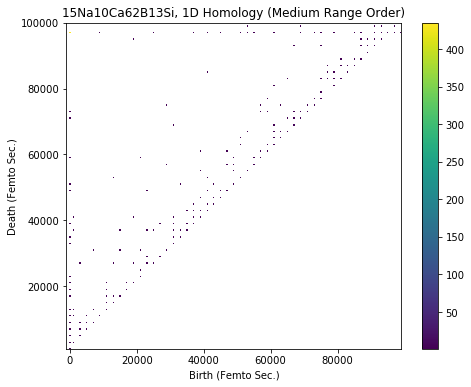

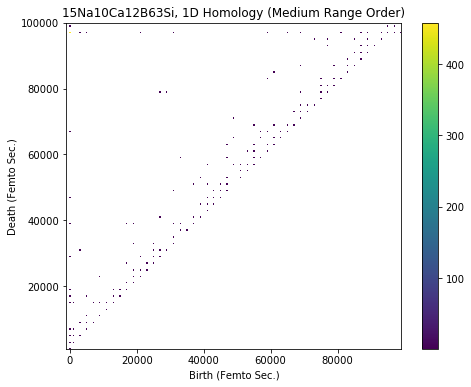

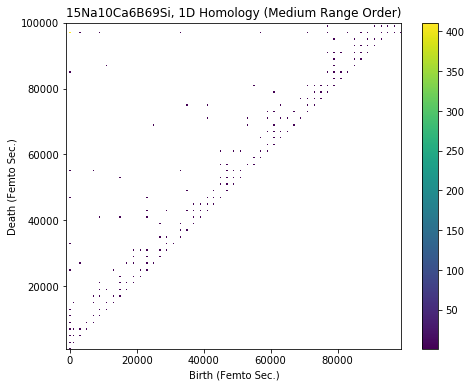

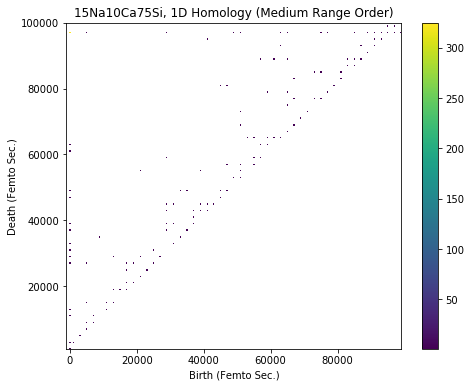

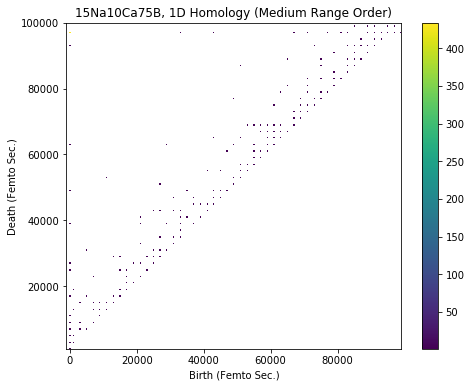

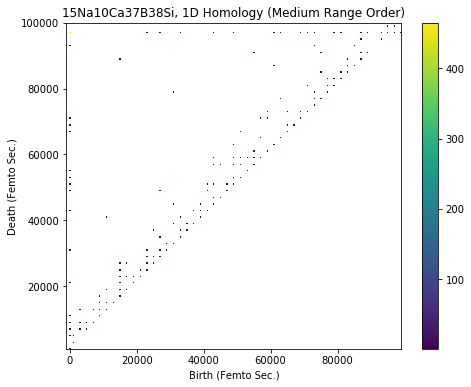

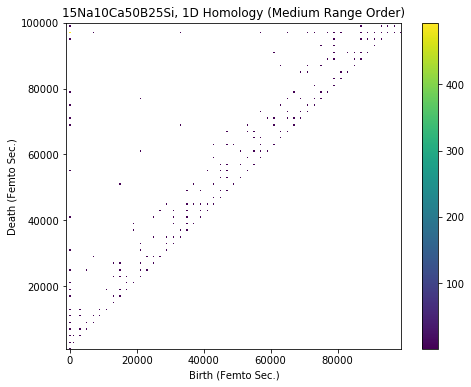

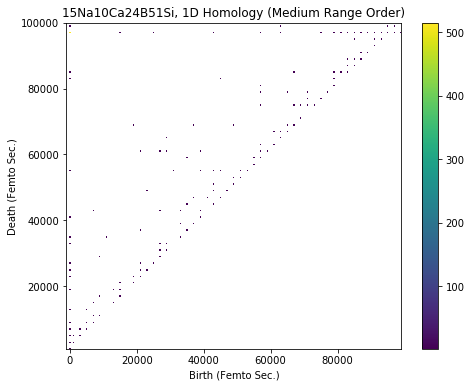

In [42]:
for comps in fn_to_read:
#     with open('./zigzag_results/'+comps+'/all.pkl', 'rb') as fp:
    with open('./zigzag_results/'+comps+'/nvt300K.pkl', 'rb') as fp:
        dgms = pickle.load(fp)
        
    fig1 = plt.figure(figsize=(7.5,6))
    ax1 = fig1.add_subplot(111)

    pts0b = []
    pts0d = []
    pts1b = []
    pts1d = []
    pts1bd = [] # storing birth and death times for cycles lived through the end of the simulation
    pts1dd = []
    pts2b = []
    pts2d = []
    for bar in dgms[0]:
    #     ax1.scatter(bar.birth, bar.death, c='C0')
        pts0b.append(bar.birth)
        pts0d.append(bar.death)
    # ax1.scatter(x=pts0b, y=pts0d, c='C0', label='0D Homo. Class', s=1)
    for bar in dgms[1]:
        if not np.isinf(bar.death):
            pts1b.append(bar.birth)
            pts1d.append(bar.death)
        elif np.isinf(bar.death):
            pts1bd.append(bar.birth)
#             pts1dd.append(2500000)

#     H, xedges, yedges = np.histogram2d(x=np.array(pts1b), y=np.array(pts1d), bins=1000)
    # ax1.matshow(H.T)
    H, xedges, yedges = np.histogram2d(x=pts1b, y=pts1d, bins=1000)
    # ax1.scatter(x=pts1b, y=pts1d, c='C1', label='1D Homo. Class', s=1)
    # ax1.scatter(1,np.inf)
    pts1dd = [xedges[-1]] * len(pts1bd)
    H, xedges, yedges, imm = ax1.hist2d(x=pts1b+pts1bd, y=pts1d+pts1dd, bins=1000, cmin=1)
#     ax1.scatter(x=pts1b+pts1bd, y=pts1d+pts1dd, c='C1', label='1D Homo. Class', s=1)
    # for bar in dgms[2]:
    #     pts2b.append(bar.birth)
    #     pts2d.append(bar.death)
    # ax1.scatter(x=pts2b, y=pts2d, c='C2', label='2D Homo. Class', s=1)

    ax1.set_xlabel('Birth (Femto Sec.)')
    ax1.set_ylabel('Death (Femto Sec.)')
    # ax1.legend()
    ax1.set_title(comps+', 1D Homology (Medium Range Order)')
    ax1.set_ylim(top=ax1.get_ylim()[-1]+1000)
    ax1.set_xlim(left=-1000)
#     for bbb, ddd in zip(pts1bd, pts1dd):
#     ax1.scatter(pts1bd, pts1dd, c='C0', s=5, label='holes with inf time')
    #     ax1.scatter(bar.birth, bar.death, c='C1')
    #     ax1.plot([bar.birth, bar.death], [yy, yy])
    #     yy += 1
#     ax1.legend(loc=4)
    fig1.colorbar(imm)
#     fig1.savefig('./zigzag_results/'+comps+'/'+comps+'alleleinf.png', dpi=250, bbox_inches='tight')
    fig1.savefig('./zigzag_results/'+comps+'/'+comps+'nvt300Kalleleinf.png', dpi=250, bbox_inches='tight')
#     fig1.savefig('./zigzag_results/'+comps+'/'+comps+'nvt300Kalleleinf.pdf', dpi=250, bbox_inches='tight')

In [1]:
# xedges[-1]
# read_out_ele[0]
# dgms[1][400]
# H
# pts1b+pts1bd
# pts1d+pts1dd